# Capstone Two: Preprocessing and Training Data Development

# Imports

In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import scipy.stats as stats
import folium

from library.sb_utils import save_file

In [2]:
df = pd.read_csv('../data/traffic_data_step3_features.csv')


In [3]:
df.shape

(199999, 38)

# Creating dummy features

In [4]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Print the list of categorical columns
print("Categorical columns:")
print(cat_cols)


Categorical columns:
['CRASH_RECORD_ID', 'CRASH_DATE', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'MOST_SEVERE_INJURY', 'LOCATION']


In [5]:
df["MOST_SEVERE_INJURY"].unique()

array(['REPORTED, NOT EVIDENT', 'NO INDICATION OF INJURY',
       'NONINCAPACITATING INJURY', 'INCAPACITATING INJURY', nan, 'FATAL'],
      dtype=object)

In [6]:
class_counts = df['MOST_SEVERE_INJURY'].value_counts()
class_counts

NO INDICATION OF INJURY     172300
NONINCAPACITATING INJURY     15367
REPORTED, NOT EVIDENT         8246
INCAPACITATING INJURY         3415
FATAL                          226
Name: MOST_SEVERE_INJURY, dtype: int64

In [7]:
# create a new column with 1 for specified categories, 0 otherwise
df['SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].apply(lambda x:
    1 if x in ['NONINCAPACITATING INJURY', 'REPORTED, NOT EVIDENT', 'REPORTED', 'INCAPACITATING INJURY', 'FATAL'] else 0)

# print the updated DataFrame
print(df.head())

                                     CRASH_RECORD_ID       CRASH_DATE  \
0  79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...  3/25/2019 14:43   
1  792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...    9/5/2018 8:40   
2  0115ade9a755e835255508463f7e9c4a9a0b47e9304238...   7/15/2022 0:45   
3  05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...  8/29/2022 11:30   
4  017040c61958d2fa977c956b2bd2d6759ef7754496dc96...  7/15/2022 18:50   

   POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
0                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
1                  30            NO CONTROLS           NO CONTROLS   
2                  30                UNKNOWN               UNKNOWN   
3                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
4                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   

  WEATHER_CONDITION LIGHTING_CONDITION FIRST_CRASH_TYPE TRAFFICWAY_TYPE  \
0             CLEAR           DAYLIGHT          TURNING         O

In [8]:
df.shape

(199999, 39)

In [9]:
class_counts = df['SEVERE_INJURY'].value_counts()
class_counts

0    172745
1     27254
Name: SEVERE_INJURY, dtype: int64

In [10]:
class_percentages = pd.Series([(x / df.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    86.372932
1    13.627068
dtype: float64

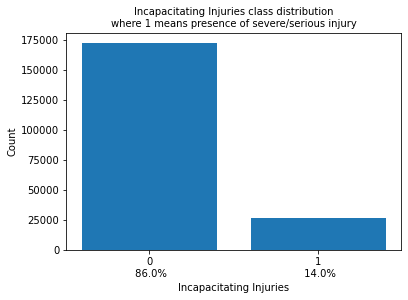

In [11]:
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(class_percentages.index.astype(str) + '\n' + ' ' +
                   class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Incapacitating Injuries')
ax.set_title('Incapacitating Injuries class distribution\nwhere 1 means presence of severe/serious injury',
              fontsize = 10)
plt.show()

Balanced and Imbalanced Classes

For a binary classification problem (two classes), the problem is called balanced if the number of elements of each class is about the same--in other words, each class would have a size that is about 50% of the total number of elements in the dataset. In this particular case study, we can say that this problem is imbalanced, since the difference in the percentages is about close to 80%. When there is a imbalance among the classes in a binary classification problem, one usually refers to them as the minority class, and the majority class.

There are two important challenges posed by ICPs:

    The difference in the size of the classes is inherent to the problem under study. This means that one cannot pave this difference by adding more elements to the minority class.

    Classification algorithms are usually negatively affected by the lack of sufficient samples of the minority class, in that the models built with them are practically unable to differentiate the minority class from the majority class, where the former is the one of interest. For instance, imagine a model built to compute the likelihod of a patient developing Cancer that nearly always predicts a small likelihood for this class (meaning, that the model predicts NO Cancer, when it should have predicted Cancer in some cases).

Since this particular case study deals with an imbalance among the classes, we will not be able to build useful models with the given dataset--without introducing additional interventions. One  approach to deal with ICP is by either generating sythetic data (a.k.a. oversampling), or by generating a set of smaller "majority classes" by taking chunks from the original majority class (a.k.a. undersampling). In general, these approaches are collectively referred to as resampling.


In [69]:
# Count the number of instances in each class
class_counts = df['SEVERE_INJURY'].value_counts()

# Calculate the minority class size
minority_class_size = class_counts[1]

# Undersample the majority class to match the minority class size
majority_class = df[df['SEVERE_INJURY'] == 0].sample(n=minority_class_size, random_state=42)

# Concatenate the minority class and the sampled majority class
balanced_data = pd.concat([df[df['SEVERE_INJURY'] == 1], majority_class])

# Shuffle the data to avoid any order effects
balanced_data = balanced_data.sample(frac=1, random_state=42)
balanced_data.head()

# Save the balanced data to a new csv file
#balanced_data.to_csv('balanced_data.csv', index=False)

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR,SEVERE_INJURY
139130,152462ef02ed078545eb56d9ab2a399f0f0547e7f8b501...,12/2/2018 5:10,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,POORLY LIT,ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,4.0,0.0,5,1,12,41.941905,-87.649418,POINT (-87.649418162633 41.941904934314),2018,0
178819,274be1520070e61fd2cd2185aca2a7ce0858d220170470...,9/22/2018 23:00,30,NO CONTROLS,NO CONTROLS,CLEAR,POORLY LIT,REAR END,ONE-WAY,STRAIGHT AND LEVEL,...,3.0,0.0,23,7,9,41.810637,-87.601869,POINT (-87.601868847824 41.810637389919),2018,0
17543,c73a860620cef835316c109717e37060208b3b0dbf21ee...,7/31/2022 11:05,40,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,6.0,0.0,11,1,7,41.904152,-87.624279,POINT (-87.624278814636 41.904152101895),2022,0
70839,8e25b549bc8b12177d8dbc11c6ba983e1b444813baa4d8...,9/8/2017 1:28,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,POORLY LIT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,...,3.0,0.0,1,6,9,41.911029,-87.648336,POINT (-87.64833580602 41.911028509812),2017,1
28299,832275562b947a07cfd64c713191034a536007c33947df...,8/28/2022 2:00,30,NO CONTROLS,NO CONTROLS,CLEAR,POORLY LIT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,1.0,0.0,2,1,8,41.918022,-87.648355,POINT (-87.648355208709 41.918022185172),2022,1


In [13]:
class_counts = balanced_data['SEVERE_INJURY'].value_counts()
class_counts

0    27254
1    27254
Name: SEVERE_INJURY, dtype: int64

In [14]:
print(balanced_data.isna().sum())

CRASH_RECORD_ID                     0
CRASH_DATE                          0
POSTED_SPEED_LIMIT                  0
TRAFFIC_CONTROL_DEVICE              0
DEVICE_CONDITION                    0
WEATHER_CONDITION                   0
LIGHTING_CONDITION                  0
FIRST_CRASH_TYPE                    0
TRAFFICWAY_TYPE                     0
ALIGNMENT                           0
ROADWAY_SURFACE_COND                0
ROAD_DEFECT                         0
REPORT_TYPE                      1863
CRASH_TYPE                          0
DAMAGE                              0
DATE_POLICE_NOTIFIED                0
PRIM_CONTRIBUTORY_CAUSE             0
SEC_CONTRIBUTORY_CAUSE              0
STREET_NO                           0
STREET_DIRECTION                    0
STREET_NAME                         0
BEAT_OF_OCCURRENCE                  0
NUM_UNITS                           0
MOST_SEVERE_INJURY                 69
INJURIES_TOTAL                     69
INJURIES_FATAL                      0
INJURIES_INC

Looking into the column Total_Injuries shows that the 441 crashes were caused by crashing into a parked vehicle or a fixed object. Thus these crashes did not result in a serious injury. 

In [15]:
df.fillna(0, inplace=True)  # replace missing values with 0


In [16]:
balanced_data['REPORT_TYPE'].fillna(df['REPORT_TYPE'].mode()[0], inplace=True)

In [17]:
balanced_data['MOST_SEVERE_INJURY'].fillna(df['MOST_SEVERE_INJURY'].mode()[0], inplace=True)
balanced_data['INJURIES_TOTAL'].fillna(df['INJURIES_TOTAL'].mode()[0], inplace=True)
balanced_data['INJURIES_INCAPACITATING'].fillna(df['INJURIES_INCAPACITATING'].mode()[0], inplace=True)
balanced_data['INJURIES_REPORTED_NOT_EVIDENT'].fillna(df['INJURIES_REPORTED_NOT_EVIDENT'].mode()[0], inplace=True)
balanced_data['INJURIES_NO_INDICATION'].fillna(df['INJURIES_NO_INDICATION'].mode()[0], inplace=True)
balanced_data['INJURIES_UNKNOWN'].fillna(df['INJURIES_UNKNOWN'].mode()[0], inplace=True)
balanced_data['LATITUDE'].fillna(df['LATITUDE'].mode()[0], inplace=True)
balanced_data['LONGITUDE'].fillna(df['LONGITUDE'].mode()[0], inplace=True)
balanced_data['LOCATION'].fillna(df['LOCATION'].mode()[0], inplace=True)
balanced_data['INJURIES_NON_INCAPACITATING'].fillna(df['INJURIES_NON_INCAPACITATING'].mode()[0], inplace=True)


In [18]:
print(balanced_data.isna().sum())

CRASH_RECORD_ID                  0
CRASH_DATE                       0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
REPORT_TYPE                      0
CRASH_TYPE                       0
DAMAGE                           0
DATE_POLICE_NOTIFIED             0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_NO                        0
STREET_DIRECTION                 0
STREET_NAME                      0
BEAT_OF_OCCURRENCE               0
NUM_UNITS                        0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
INJURIES_INCAPACITATING          0
INJURIES_NON_INCAPACITATING      0
INJURIES_REPORTED_NO

In [19]:
balanced_data.shape

(54508, 39)

In [20]:
categorical = balanced_data.select_dtypes(include=['object']).columns.tolist()

# Print the list of categorical columns
print("Categorical columns:")
print(cat_cols)

Categorical columns:
['CRASH_RECORD_ID', 'CRASH_DATE', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'MOST_SEVERE_INJURY', 'LOCATION']


In [21]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
le = LabelEncoder()

# Loop over each categorical variable and encode its values
for col in categorical :
    balanced_data[col] = le.fit_transform(balanced_data[col].astype(str))

In [22]:
balanced_data.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR,SEVERE_INJURY
139130,14610,13817,30,15,1,6,4,0,2,3,...,4.0,0.0,5,1,12,41.941905,-87.649418,13297,2018,0
178819,27140,49820,30,4,3,1,4,10,10,3,...,3.0,0.0,23,7,9,41.810637,-87.601869,3002,2018,0
17543,53406,40438,40,4,3,1,2,10,3,3,...,6.0,0.0,11,1,7,41.904152,-87.624279,6560,2022,0
70839,49157,51944,30,16,1,1,4,17,8,3,...,3.0,0.0,1,6,9,41.911029,-87.648336,13028,2017,1
28299,41535,45727,30,4,3,1,4,8,8,3,...,1.0,0.0,2,1,8,41.918022,-87.648355,13035,2022,1


In [53]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54508 entries, 139130 to 114054
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54508 non-null  int32  
 1   CRASH_DATE                     54508 non-null  int32  
 2   POSTED_SPEED_LIMIT             54508 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE         54508 non-null  int32  
 4   DEVICE_CONDITION               54508 non-null  int32  
 5   WEATHER_CONDITION              54508 non-null  int32  
 6   LIGHTING_CONDITION             54508 non-null  int32  
 7   FIRST_CRASH_TYPE               54508 non-null  int32  
 8   TRAFFICWAY_TYPE                54508 non-null  int32  
 9   ALIGNMENT                      54508 non-null  int32  
 10  ROADWAY_SURFACE_COND           54508 non-null  int32  
 11  ROAD_DEFECT                    54508 non-null  int32  
 12  REPORT_TYPE                    54508 non

# Scale: standardization

Preprocessing the target value for a classification problem depends on the specific problem and the type of classifier being used. In general, it is not necessary to preprocess the target variable, as it is already in a format suitable for most classification algorithms. However, there may be certain cases where preprocessing the target variable is necessary or can improve the performance of the model.

For example, in our example the target variable is imbalanced, meaning that the target variable class has significantly low samples than the other classes. Thus,  it is necessary to balance the classes by oversampling or undersampling the data. This can help the model to learn the minority class better and improve its performance.

In [23]:
from sklearn.preprocessing import StandardScaler
# Select the numeric columns
numeric_cols = balanced_data.select_dtypes(include=['float64']).columns.tolist()

# Create a scaler object
scaler = StandardScaler()

# Standardize the numeric columns


balanced_data[numeric_cols] = scaler.fit_transform(balanced_data[numeric_cols])




# Split data into training and testing subsets

In [24]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = balanced_data.drop('SEVERE_INJURY', axis=1) # all columns except the target
print(X.shape)
y = balanced_data['SEVERE_INJURY'] # target variable
print (y.shape)



(54508, 38)
(54508,)


In [54]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [70]:
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)

In [64]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1000, max_iter=500, solver='liblinear')

In [65]:
print(f'Accuracy on training data: {accuracy_score(classifier.predict(X_train), y_train):.2f}')

Accuracy on training data: 1.00


In [66]:
print(f'Accuracy on test data: {accuracy_score(classifier.predict(X_test), y_test):.2f}')

Accuracy on test data: 1.00


In [67]:
print("Classification Report for Training Data")
print(classification_report(y_train, classifier.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21817
           1       1.00      1.00      1.00     21789

    accuracy                           1.00     43606
   macro avg       1.00      1.00      1.00     43606
weighted avg       1.00      1.00      1.00     43606



In [68]:
print("Classification Report for Test Data")
print(classification_report(y_test, classifier.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5437
           1       1.00      1.00      1.00      5465

    accuracy                           1.00     10902
   macro avg       1.00      1.00      1.00     10902
weighted avg       1.00      1.00      1.00     10902



In [44]:
from sklearn import tree, metrics

# Declare a variable called entr_model and use tree.DecisionTreeClassifier. 
entr_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=1234)

# Call fit() on entr_model
entr_model.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred=entr_model.predict(X_test)

# Call Series on our y_pred variable with the following: pd.Series(y_pred)
y_pred=pd.Series(y_pred)

# Check out entr_model
entr_model



DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [52]:
from io import StringIO  
import pydotplus
#from IPython.display import Imag


# Run this block for model evaluation metrics 
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = 0))



Model Entropy - no max depth
Accuracy: 1.0
Balanced accuracy: 1.0
Precision score for "Yes" 1.0
Precision score for "No" 1.0
Recall score for "Yes" 1.0
Recall score for "No" 1.0
